In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import all
import tarfile, os, torch

import random as rd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from fnmatch import fnmatch

from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Define the path to the zipped folder in your Google Drive
tar_file_path = '/content/drive/MyDrive/RNAStralign.tar.gz' #Change!

# Define the folder where you want to unzip the files (in-memory)
extracted_folder = '/content/sequences' #Change name?!

# Import files

In [4]:
# Create the destination folder (in-memory)
os.makedirs(extracted_folder, exist_ok=True)

# Extract the tar.gz archive
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall(extracted_folder)

# List the files in the extracted folder
os.listdir(extracted_folder)

['RNAStrAlign-master-aedbaf9e95ebad34d15752fe1b750f5ff3960bca']

In [5]:
root = extracted_folder
pattern = "*.ct"

ct_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            ct_files.append(os.path.join(path, name))
with open("ct_files.txt", "w") as output:
    output.write("\n".join(ct_files))


### Picking files

In [6]:
def singleFamily(family: str, txt_file="ct_files.txt") -> list:
    '''
    Returns list of files from a single specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family in line:
                ct_files.append(line.strip())
    return ct_files

def leaveOneFamilyOut(family: str, txt_file="ct_files.txt"):
    '''
    Returns list of files from all families except the specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family not in line:
                ct_files.append(line.strip())
    return ct_files

def pickFromFamilies(data_size, txt_file="ct_files.txt"):
    '''
    Returns a list of files with data_size from EACH family.
    If a family does not have enough data, all data from that family is added.
    '''
    ct_files = []
    with open(txt_file, "r") as file: #Read paths to ct_files
        for line in file:
            if not line.startswith("#"):
                ct_files.append(line.strip())

    families = []
    for file in ct_files: #Find all family names
        #print(file.split("/"))
        families.append(file.split(os.sep)[4])
    families = list(set(families)) #Remove duplicates
    print(families)

    data = [] #Create list of lists, where each list contains all files from a family
    for family in families:
        data.append([line for line in ct_files if family in line])

    ct_files = []
    for family in data: #Pick data_size files from each family
      try:
          ct_files+=rd.sample(family, data_size)
      except:
          print("Not enough data in family: ", family[0].split(os.sep)[4], " for size: ", data_size, ".\n Missing", data_size-len(family),"files.","\n Adding all data from family.")
          ct_files+=family
    return ct_files

def getLength(ct_file):
    with open(ct_file, "r") as f:
      for line in f:
        length = int(line.split()[0])
        break
    return length

def underGivenLength(length, data_size, txt_file="ct_files.txt"):
  '''
  Returns a list of files under length with data_size from EACH family.
  If a family does not have enough data, all data from that family is added.
  '''
  ct_files = []
  with open(txt_file, "r") as file: #Read paths to ct_files
      for line in file:
          if not line.startswith("#"):
              ct_files.append(line.strip())

  families = []
  for file in ct_files: #Find all family names
      families.append(file.split(os.sep)[4])
  families = list(set(families)) #Remove duplicates

  data = [] #Create list of lists, where each list contains all files from a family
  for family in families:
      data.append([line for line in ct_files if family in line and getLength(line)<length])

  ct_files = []
  for family in data: #Pick data_size files from each family
      try:
          ct_files+=rd.sample(family, data_size)
      except:
          print("Not enough data in family, adding all")
          #print("Not enough data in family: ", family[0].split(os.sep)[4], " for size: ", data_size, ".\n Missing", data_size-len(family),"files.","\n Adding all data from family.")
          ct_files+=family
  return ct_files



# Set up preprocessing of RNA files   

Below are the functions that is needed for processing the files from .ct files to images

In [7]:
def read_bpseq(file: str) -> tuple():
    """
    Takes a .bpseq file and returns the sequence as a string and a list of base pairs
    """

    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    #Make sequence in bp list
    for line in lines:
        sequence += line[1]
        if line[2] != '0':
            pairs.append((int(line[0])-1, int(line[2])-1)) #The files start indexing from 1
    return sequence, pairs

def read_ct(file: str) -> tuple():
    """
    Takes a .ct file and returns the sequence as a string and a list of base pairs
    """
    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    for line in lines:
        sequence += line[1]
        if line[4] != '0':
            pairs.append((int(line[0])-1, int(line[4])-1)) #The files start indexing from 1

    return sequence, pairs

In [8]:
def make_matrix_from_sequence(sequence: str) -> np.array:
    """
    A sequence is converted to a matrix containing all the possible base pairs

    If the bases does not form  valid pair the cell is white.
    The valid base pairs has the following colors:
    GC = green
    CG = dark green
    UG = blue
    GU = dark blue
    UA = red
    AU = dark red
    """
    colors = {"invalid_pairing": [255, 255, 255],
              "unpaired": [64, 64, 64],
              "GC": [0, 255, 0],
              "CG": [0, 128, 0],
              "UG": [0, 0, 255],
              "GU": [0, 0, 128],
              "UA": [255, 0, 0],
              "AU": [128, 0, 0]}
    basepairs = ["GC", "CG", "UG", "GU", "UA", "AU"]

    N = len(sequence)

    matrix = np.full((N,N,3),255, dtype="uint8")

    for i in range(N):
        for j in range(N):
            pair = sequence[i] + sequence[j]
            if i == j:
                matrix[i, j, :] = colors["unpaired"]
            elif pair in basepairs:
                matrix[i, j, :] = colors[pair]

    if N%2==0:
      row = np.full((1, N, 3), 0, dtype="uint8")
      column = np.full((N+1, 1, 3), 0, dtype="uint8")
      matrix = np.append(matrix, row, axis = 0)
      matrix = np.append(matrix, column, axis = 1)

    return matrix


def make_matrix_from_basepairs(sequence: str, pairs: list) -> np.array:
    """
    Takes a list of all the base pairs.
    From the list a matrix is made, with each cell coresponding to a base pair colered black
    """
    black = [0, 0, 0]

    N = len(sequence)
    matrix = np.full((N,N,3),255, dtype="uint8")

    for pair in pairs:
        matrix[pair[0], pair[1], :] = black

    if N%2==0:
      row = np.full((1, N, 3), 0, dtype="uint8")
      column = np.full((N+1, 1, 3), 0, dtype="uint8")
      matrix = np.append(matrix, row, axis = 0)
      matrix = np.append(matrix, column, axis = 1)

    return matrix

In [9]:
def save_matrix(matrix: np.array, name: str) -> None:
    """
    Saves the matrix as a .png file
    """
    plt.imsave(name, matrix)

# Convert sequences
The sequences needs to be read from the .ct files and converted into images that can be used as input to the CNN.    

In [10]:
def getCtFromTxt(txt_file):
    """
    Takes a txt file containing the path to all the ct files and returns a list of the paths
    """
    with open(txt_file, 'r') as f:
        ct_files = f.readlines()
    ct_files = [file.strip() for file in ct_files if file.strip()[0] != "#"]
    return ct_files

def save_to_matrices(file_list, input_matrix_path, output_matrix_path):
    """
    For every file supplied in file_list:
      a matrix of all possible base pairs is saved to input_matrix_path
      a matrix showing the base pairs in the actual sequence is saved to output_matrix_path
    """
    for file_name in file_list:
      try:
        sequence, pairs = read_ct(file_name)
        input_matrix = make_matrix_from_sequence(sequence)
        output_matrix = make_matrix_from_basepairs(sequence, pairs)
        save_matrix(input_matrix, os.path.join(input_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))
        save_matrix(output_matrix, os.path.join(output_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))
      except:
        print("Error in file, skipping")

In [11]:
#TODO - Change to different file list! This is just for testing.

ct_files = getCtFromTxt("ct_files.txt")

file_list = leaveOneFamilyOut("5S_rRNA")

with open("ct_files_no_5S.txt", "w") as output:
    output.write("\n".join(file_list))

file_list = underGivenLength(500, 5000, "ct_files_no_5S.txt")

len(file_list)

Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all


9631

In [12]:
input_matrix_path = "input"
output_matrix_path = "result"

# Create folders for images
os.makedirs(input_matrix_path, exist_ok=True)
os.makedirs(output_matrix_path, exist_ok=True)

save_to_matrices(file_list, input_matrix_path, output_matrix_path)


In [25]:
!cp -r /content/train /content/drive/MyDrive/deep_learning_project
!cp -r /content/validation /content/drive/MyDrive/deep_learning_project

# Set up data for network

### Splitting data into train and validation sets

In [14]:
def move_files(src_dir, dst_dir, file_list):
    for filename in file_list:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        os.rename(src_path, dst_path)

In [15]:
#Make directories
directories = ['train', 'validation']
subdirectories = ['input_images', 'output_images']

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    for subdirectory in subdirectories:
        dir_path = os.path.join(directory, subdirectory)
        os.makedirs(dir_path, exist_ok=True)

In [16]:
#List input and outputs
input_images = os.listdir(input_matrix_path)
output_images = os.listdir(output_matrix_path)

#Make split
input_train, input_valid, output_train, output_valid = train_test_split(input_images, output_images, train_size=0.8, random_state=42, shuffle=True) #NOTE - Change to the fraction we want nd whether we want shuffle or not


#Move files to train and validation folders
train_input_dir = 'train/input_images'
train_output_dir = 'train/output_images'
val_input_dir = 'validation/input_images'
val_output_dir = 'validation/output_images'

move_files(input_matrix_path, train_input_dir, input_train)
move_files(output_matrix_path, train_output_dir, output_train)
move_files(input_matrix_path, val_input_dir, input_valid)
move_files(output_matrix_path, val_output_dir, output_valid)

### Read data and set up data loader

In [17]:
class ImageToImageDataset(Dataset):
    """

    """
    def __init__(self, input_dir, output_dir, transform = None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = os.listdir(input_dir)
        self.output_files = os.listdir(output_dir)
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_image =  plt.imread(os.path.join(self.input_dir, self.input_files[idx]))
        output_image = plt.imread(os.path.join(self.output_dir, self.output_files[idx]))

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return input_image, output_image

dataTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
])


In [18]:
train_dataset = ImageToImageDataset(train_input_dir, train_output_dir, dataTransformer)
validation_dataset = ImageToImageDataset(val_input_dir, val_output_dir, dataTransformer)

batch_size = 1 #NOTE - Change?!

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #Do shuffle need to be true???
val_loader = DataLoader(validation_dataset, batch_size=batch_size)

# Model

In [19]:
class RNASecondaryStructureCAE(nn.Module):
    def __init__(self, num_hidden_channels, num_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNASecondaryStructureCAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_hidden_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(num_hidden_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=num_hidden_channels,
                out_channels=num_hidden_channels * 2,
                kernel_size=3,
                padding=2,
                dilation=2
                # Maybe use dilation in deeper layers?
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Doesn't make sense for our data?
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=num_hidden_channels * 2,
                out_channels=num_hidden_channels,
                kernel_size=3,
                stride=2,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=num_hidden_channels,
                out_channels=num_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Function for training the model

### Loss functions

In [20]:
class DICE(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
      super().__init__(*args, **kwargs)

### Optimizers

In [21]:
def adam_optimizer(model, lr):
  return torch.optim.Adam(model.parameters(), lr=lr)

### Plots for training

In [22]:
def show_matrices(inputs, observed, predicted):

  fig, axs = plt.subplots(1, 3, figsize=(6,2))

  axs[0].imshow(inputs.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[0].set_title("Input")

  axs[1].imshow(observed.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[1].set_title("Observed")

  axs[2].imshow(predicted.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[2].set_title("Predicted")

  plt.tight_layout()
  plt.show()


def show_loss(train_time, train_loss, valid_time, valid_loss):
  plt.figure()
  plt.plot(train_time, train_loss, label = "Training")
  plt.plot(valid_time, valid_loss, label = "Valiation")
  plt.title("Loss")
  plt.legend()
  plt.show()

def showEpochLoss(train_epochs, train_loss_epochs, valid_time, valid_loss):
  plt.figure()
  plt.plot(train_epochs, train_loss_epochs, label = "Training")
  plt.plot(valid_time, valid_loss, label = "Validation")
  plt.title("Loss")
  plt.legend()
  plt.show()

### Funcition for training

In [23]:
def fit_model(model, train_dataset, validation_dataset, loss_func = F.binary_cross_entropy, optimizer = adam_optimizer, lr=0.01, bs=1, epochs=5):
  train_dl = DataLoader(train_dataset, batch_size=bs)
  valid_dl = DataLoader(validation_dataset, batch_size=bs)

  opt = optimizer(model, lr)

  #Add stuff to track history
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []
  plot_epochs = []
  plot_epoch_loss = []

  t = 1 #To keep track of time

  # Get initial validation loss and accuracy
  model.eval()

  #Train for a given number of epochs
  for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for input, output in train_dl:
      #Forward pass
      predicted = model(input.cuda())

      #Compute loss
      loss = loss_func(predicted, output.cuda())
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backpropagation, optimization and zeroing the gradients
      loss.backward()
      opt.step()
      opt.zero_grad()

      running_loss += loss.item()

    #Validation loss (only after each epoch)
    model.eval()
    with torch.no_grad():
      valid_loss = sum(loss_func(model(input.cuda()), output.cuda()) for input, output in valid_dl)/len(valid_dl)
      valid_loss_history.append(valid_loss.detach().cpu().numpy())
      plot_time_valid.append(t-1)

    show_matrices(input, output, predicted)
    plot_epochs.append(epoch+1)
    plot_epoch_loss.append(running_loss/len(train_dl))

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {round(running_loss / len(train_dl),4)}")

  #Loss plot
  show_loss(plot_time_train, train_loss_history, plot_time_valid, valid_loss_history)
  showEpochLoss(plot_epochs, plot_epoch_loss, plot_epochs, valid_loss_history)



# Training models

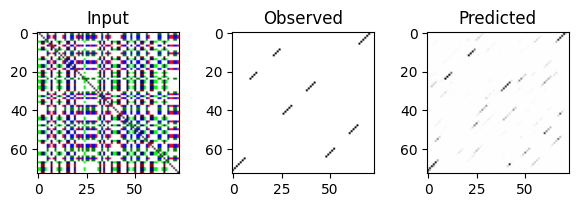

Epoch [1/20], Loss: 0.0119


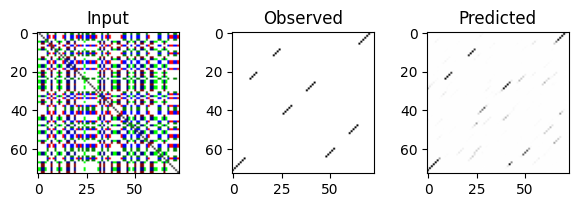

Epoch [2/20], Loss: 0.0082


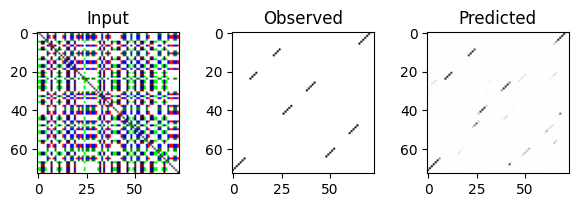

Epoch [3/20], Loss: 0.0077


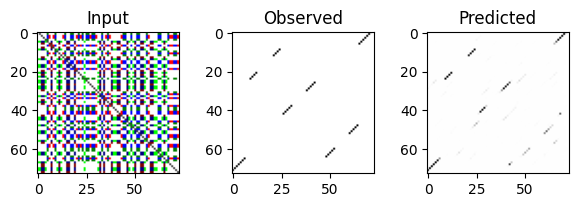

Epoch [4/20], Loss: 0.0075


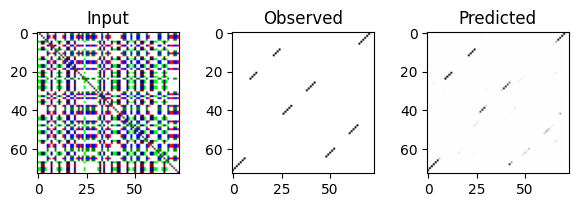

Epoch [5/20], Loss: 0.0074


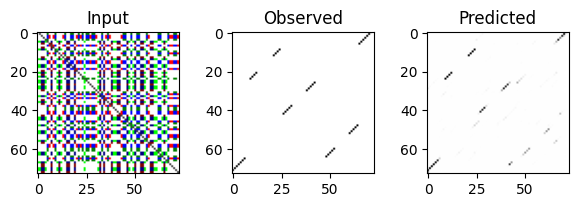

Epoch [6/20], Loss: 0.0073


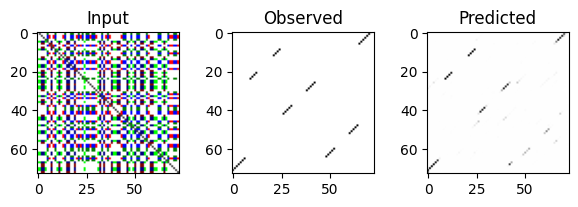

Epoch [7/20], Loss: 0.0072


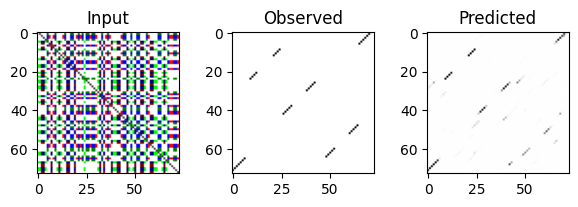

Epoch [8/20], Loss: 0.0071


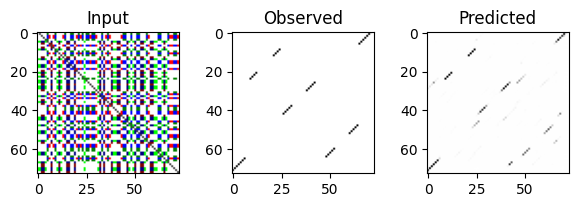

Epoch [9/20], Loss: 0.0071


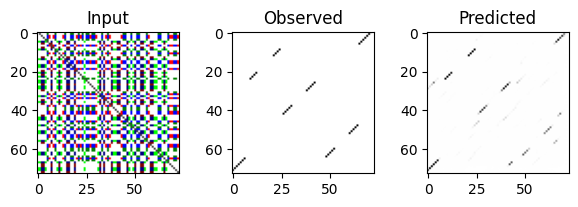

Epoch [10/20], Loss: 0.007


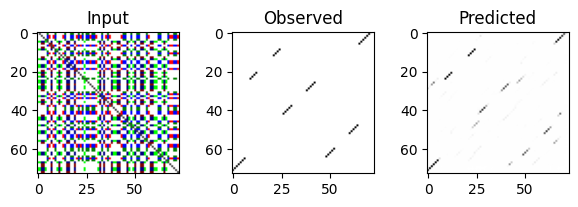

Epoch [11/20], Loss: 0.007


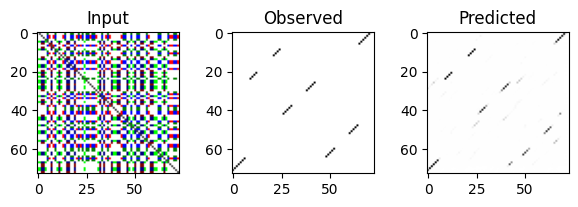

Epoch [12/20], Loss: 0.007


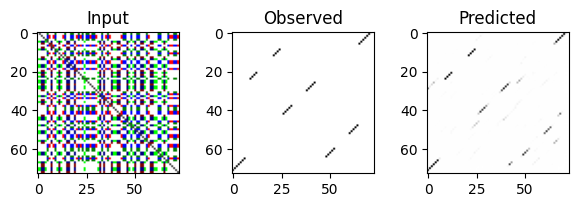

Epoch [13/20], Loss: 0.007


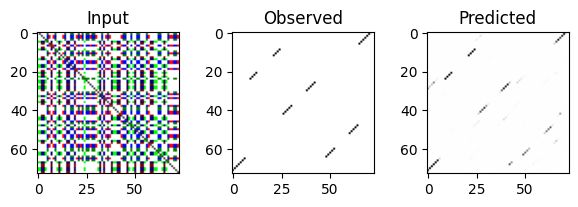

Epoch [14/20], Loss: 0.007


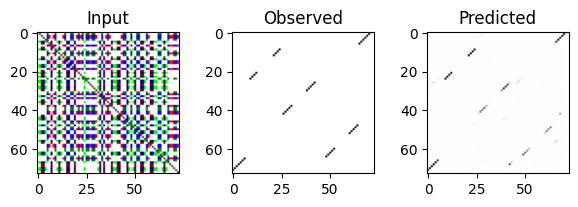

Epoch [15/20], Loss: 0.007


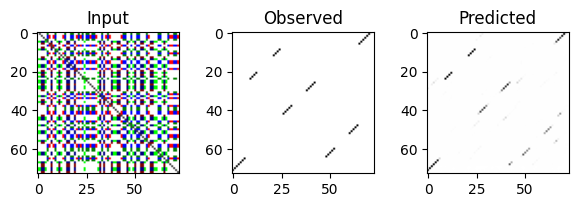

Epoch [16/20], Loss: 0.007


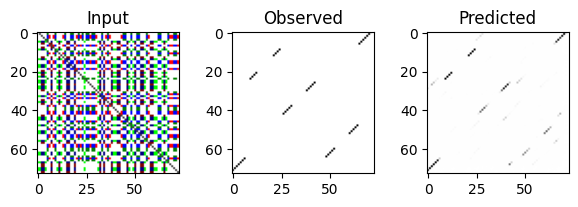

Epoch [17/20], Loss: 0.007


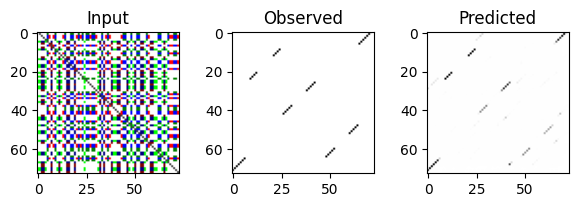

Epoch [18/20], Loss: 0.007


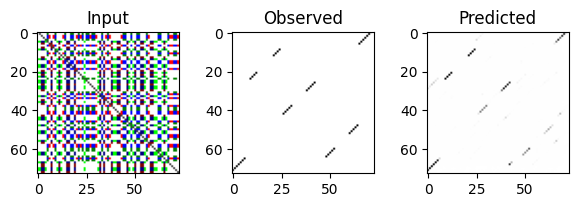

Epoch [19/20], Loss: 0.0069


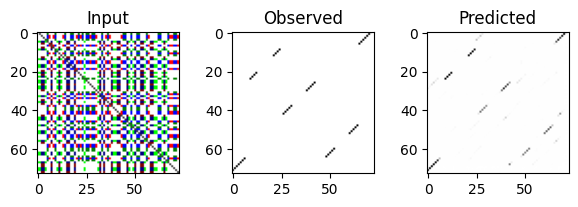

Epoch [20/20], Loss: 0.0069


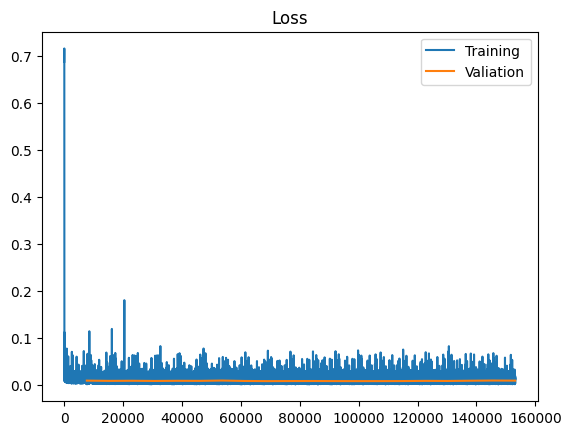

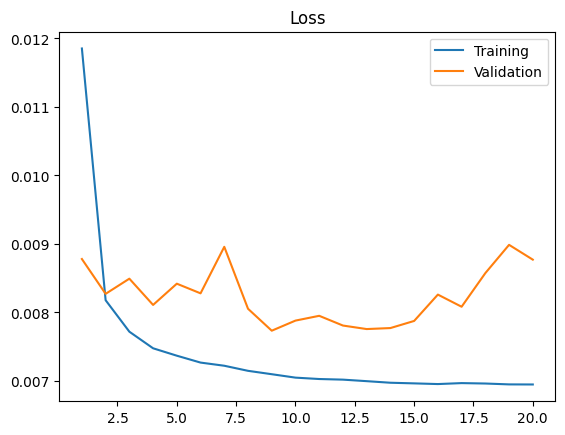

Training finished


In [24]:
%matplotlib inline

num_input_channels = 8
cae = RNASecondaryStructureCAE(num_input_channels).cuda()

fit_model(cae, train_dataset, validation_dataset, lr=0.01, epochs=20)

print("Training finished")